<a href="https://colab.research.google.com/github/Ghzraza/synthetic-social-network-analysis/blob/main/Social_Network_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 5, Loss=0.0797
Epoch 10, Loss=0.0192
Epoch 15, Loss=0.0102
Epoch 20, Loss=0.0057


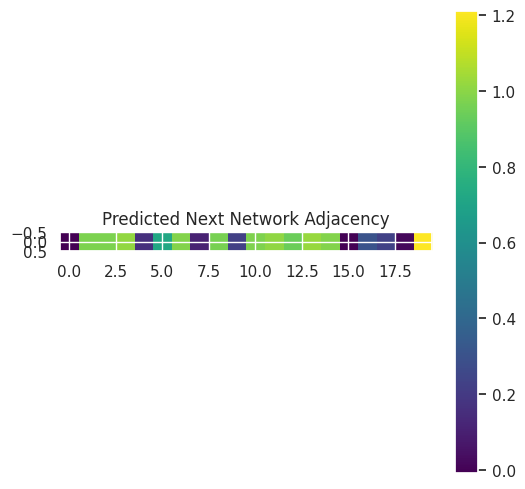

'\nThis notebook demonstrates transferability to Labonté Lab projects:\n\n1. Computational Neuroscience:\n   - Nodes = neurons in mPFC\n   - Temporal evolution = recruitment of ensembles\n   - Clustering = functional neuronal groups\n   - RNN prediction = in silico modeling of circuit activity\n\n2. Neuroethological Social Dynamics:\n   - Nodes = mice in social colonies\n   - Temporal evolution = social interactions over time\n   - Clustering = social clusters / hierarchies\n   - RNN prediction = forecasting social behavior under constraints\n'

In [5]:
# SNA_Synthetic_Interactions.ipynb
# Author: Ghazal Raza
# Purpose: Temporal network analysis, clustering, and AI prediction of synthetic interactions
# For Labonté Lab projects (neuronal circuits & social dynamics)

# --- 0. Setup ---
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
sns.set()

# Ensure results folders exist
os.makedirs('results/network_plots', exist_ok=True)
os.makedirs('results/predicted_networks', exist_ok=True)

# --- 1. Function Definitions (self-contained) ---

# 1a. Network generation
def generate_synthetic_network(num_nodes=20, p_edge=0.2, seed=42):
    import random
    np.random.seed(seed)
    random.seed(seed)
    G = nx.erdos_renyi_graph(n=num_nodes, p=p_edge, seed=seed)
    for node in G.nodes():
        G.nodes[node]['type'] = random.choice(['agent_A','agent_B'])
    return G

# 1b. Network evolution
def evolve_network(G, steps=10, p_add=0.1, p_remove=0.05):
    evolution = []
    G_curr = G.copy()
    for t in range(steps):
        G_next = G_curr.copy()
        # Add edges
        for i in G_curr.nodes():
            for j in G_curr.nodes():
                if i != j and not G_curr.has_edge(i,j) and np.random.rand() < p_add:
                    G_next.add_edge(i,j)
        # Remove edges
        for i,j in list(G_curr.edges()):
            if np.random.rand() < p_remove:
                G_next.remove_edge(i,j)
        evolution.append(G_next)
        G_curr = G_next
    return evolution

# 1c. Clustering
from sklearn.cluster import SpectralClustering
def cluster_network(G, n_clusters=2):
    adj = nx.to_numpy_array(G)
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = clustering.fit_predict(adj)
    return labels

# 1d. RNN Prediction
class NetworkDataset(Dataset):
    def __init__(self, evolution):
        self.data = []
        for t in range(len(evolution)-1):
            X = nx.to_numpy_array(evolution[t])
            y = nx.to_numpy_array(evolution[t+1])
            self.data.append((X,y))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        X, y = self.data[idx]
        return torch.tensor(X,dtype=torch.float32), torch.tensor(y,dtype=torch.float32)

class SimpleRNN(nn.Module):
    def __init__(self, num_nodes, hidden_size=64):
        super(SimpleRNN,self).__init__()
        self.rnn = nn.RNN(input_size=num_nodes, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_nodes)
    def forward(self, x):
        out,_ = self.rnn(x)
        out = self.fc(out[:,-1,:])
        return out

def train_rnn(evolution, num_nodes=20, epochs=20, lr=0.01):
    dataset = NetworkDataset(evolution)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model = SimpleRNN(num_nodes)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        total_loss = 0
        for X, y in loader:
            optimizer.zero_grad()
            X_rnn = X[:,0,:].unsqueeze(1)  # batch, seq_len=1, features
            y_rnn = y[:,0,:]
            output = model(X_rnn)
            loss = criterion(output, y_rnn)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1)%5==0:
            print(f"Epoch {epoch+1}, Loss={total_loss/len(loader):.4f}")
    return model

def predict_next_network(model, last_network):
    X_last = torch.tensor(nx.to_numpy_array(last_network), dtype=torch.float32)
    X_last = X_last[None, :, 0].unsqueeze(1)  # batch=1, seq_len=1, num_nodes
    predicted_adj = model(X_last).detach().numpy()
    return predicted_adj

# 1e. Plotting utility
def plot_and_save_network(G, labels=None, title="Network", filename="network.png"):
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=42)
    if labels is None:
        nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
    else:
        nx.draw(G, pos, with_labels=True, node_color=labels, cmap=plt.cm.Set2, edge_color='gray')
    plt.title(title)
    plt.savefig(filename)
    plt.close()

# --- 2. Run Workflow ---

# Generate network
G0 = generate_synthetic_network(num_nodes=20, p_edge=0.2)
plot_and_save_network(G0, title="Initial Network", filename='results/network_plots/initial_network.png')

# Evolve network
evolution = evolve_network(G0, steps=10)

# Cluster and save plots
for t, Gt in enumerate(evolution):
    labels = cluster_network(Gt, n_clusters=2)
    plot_and_save_network(Gt, labels=labels, title=f"Network t={t+1}",
                          filename=f'results/network_plots/network_t{t+1}.png')

# Train RNN
model = train_rnn(evolution, num_nodes=20, epochs=20, lr=0.01)

# Predict next network
predicted_adj = predict_next_network(model, evolution[-1])
plt.figure(figsize=(6,6))
plt.imshow(predicted_adj, cmap='viridis')
plt.colorbar()
plt.title("Predicted Next Network Adjacency")
plt.savefig('results/predicted_networks/predicted_next_network.png')
plt.show()

# --- 3. Laval-Specific Comments ---
"""
This notebook demonstrates transferability to Labonté Lab projects:

1. Computational Neuroscience:
   - Nodes = neurons in mPFC
   - Temporal evolution = recruitment of ensembles
   - Clustering = functional neuronal groups
   - RNN prediction = in silico modeling of circuit activity

2. Neuroethological Social Dynamics:
   - Nodes = mice in social colonies
   - Temporal evolution = social interactions over time
   - Clustering = social clusters / hierarchies
   - RNN prediction = forecasting social behavior under constraints
"""


In [6]:
# 1. Configure Git
!git config --global user.email "ghazalraza66@gmail.com"
!git config --global user.name "Ghzraza"

# 2. Clone your repo
!git clone https://github.com/<username>/<repo>.git
%cd <repo>  # move into repo folder

# 3. Copy results folder from Colab
!cp -r /content/results ./results  # adjust path if different

# 4. Add, commit, and push
!git add results
!git commit -m "Add full results folder from Colab"
!git push origin main  # or master

/bin/bash: line 1: username: No such file or directory
[Errno 2] No such file or directory: '<repo> # move into repo folder'
/content
cp: cannot copy a directory, '/content/results', into itself, './results/results'
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
